In [117]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import imutils
import easyocr

class LicensePlateDetector:
    def __init__(self, pth_weights: str, pth_cfg: str, pth_classes: str):
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg)
        self.classes = []
        with open(pth_classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
#detect a license plate from the input image and draw a rectangle around it        
    def detect(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                if confidence > 0.2:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(img, (x,y), (x + w, y + h), self.color, 15)
                cv2.putText(img, label + ' ' + confidence, (x, y + 20), self.font, 3, (255, 255, 255), 3)
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return
    
#Crop the detected license plate from an image to apply some OCR to extract the text    
    def crop_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h, x:x + w]
        self.roi_image = roi
        return

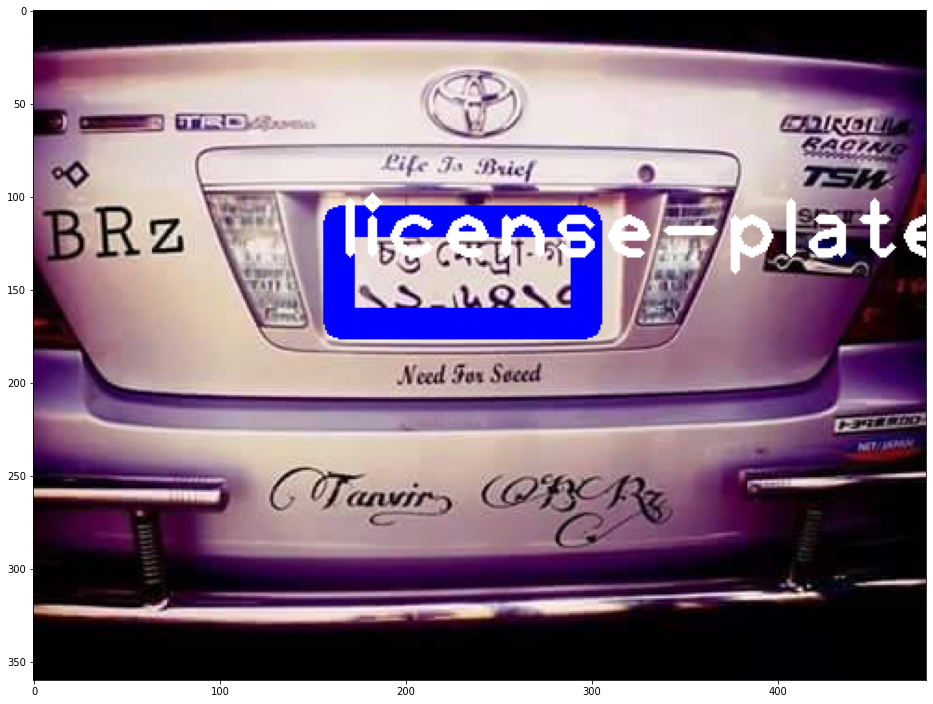

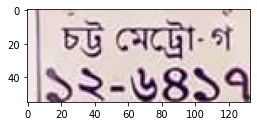

In [118]:
lpd = LicensePlateDetector(
    pth_weights='yolov3-train_final.weights', 
    pth_cfg='yolov3_testing.cfg', 
    pth_classes='classes.txt'
)

# Detect license plate
lpd.detect('73.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('detected.jpg')
plt.show()

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(4, 4))
img=cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [119]:
read_char= easyocr.Reader(['bn'])  #bangla character reading with 'bn'
detected= read_char.readtext(img)  #read from final extracted plate

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [120]:
detected

[([[16, 4], [126, 4], [126, 32], [16, 32]],
  'চট্ট মেট্রো-গ',
  0.5152070073652495),
 ([[8, 30], [132, 30], [132, 55], [8, 55]], '১২-৬৪১৭', 0.9193279677886901)]